In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Data  for df_ecom
df_cust= pd.read_csv(r"files\customer_details.csv")
df_cust['Age']=df_cust['Age'].astype(str)
#Data  for df_ecom
df_ecom= pd.read_csv(r"files\E-commerece sales data 2024.csv")
delete=df_ecom.columns[4]
df_ecom.drop(labels=delete,axis=1,inplace=True)
df_ecom=df_ecom.dropna(how='all')
# Data Cleanup for df_prod
df_prod= pd.read_csv(r"files\product_details.csv")
drop_list=df_prod.columns[[2,3,5,6,8,15,17,18,19,20,21,22,23,24,26,27]].to_list()
df_prod.drop(labels=drop_list,axis=1,inplace=True)
df_prod['Selling Price']=df_prod['Selling Price'].replace('[\$,]','',regex=True)
df_prod=df_prod.rename(columns={'Uniqe Id':'Unique Id'})
df_prod['Selling Price']=pd.to_numeric(df_prod['Selling Price'],errors='coerce')
df_prod['Selling Price']=df_prod['Selling Price'].fillna(0).astype(int)
def convert_to_pounds(weight_str):
    # Check if the input is a string
    if isinstance(weight_str, str):
        # Regular expression to match the numeric part and the unit
        match = re.match(r'([\d.]+)\s*(pounds|ounces)', weight_str.strip())
        if match:
            try:
                value = float(match.group(1))
                unit = match.group(2)
                if unit == 'ounces':
                    # Convert ounces to pounds
                    return value * 0.0625
                else:
                    # Already in pounds
                    return value
            except ValueError:
                # Handle conversion errors
                return None
    # Return None for non-string values or invalid formats
    return None
df_prod['Shipping Weight (lbs)']=df_prod['Shipping Weight'].apply(convert_to_pounds)
df_prod.drop(labels='Shipping Weight',axis=1,inplace=True)
df_prod['Category']=df_prod['Category'].fillna('')
df_prod['CategorySplit']=df_prod['Category'].str.split('|')
df_prod['HeadCategory']=df_prod['CategorySplit'].apply(lambda x:x[0] if isinstance(x, list) and len(x) > 0 else None)
df_prod['HeadCategory']=df_prod['HeadCategory'].str.strip()
df_prod['SubCategory']=df_prod['CategorySplit'].apply(lambda x: '|'.join(x[1:]) if isinstance(x, list) and len(x) > 1 else None)
df_prod.drop(columns=['CategorySplit'], inplace=True)

<>:20: SyntaxWarning: invalid escape sequence '\$'
<>:20: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Jesse\AppData\Local\Temp\ipykernel_16784\130215932.py:20: SyntaxWarning: invalid escape sequence '\$'
  df_prod['Selling Price']=df_prod['Selling Price'].replace('[\$,]','',regex=True)


C:\Users\Jesse\AppData\Local\Temp\ipykernel_16784\3316426896.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')


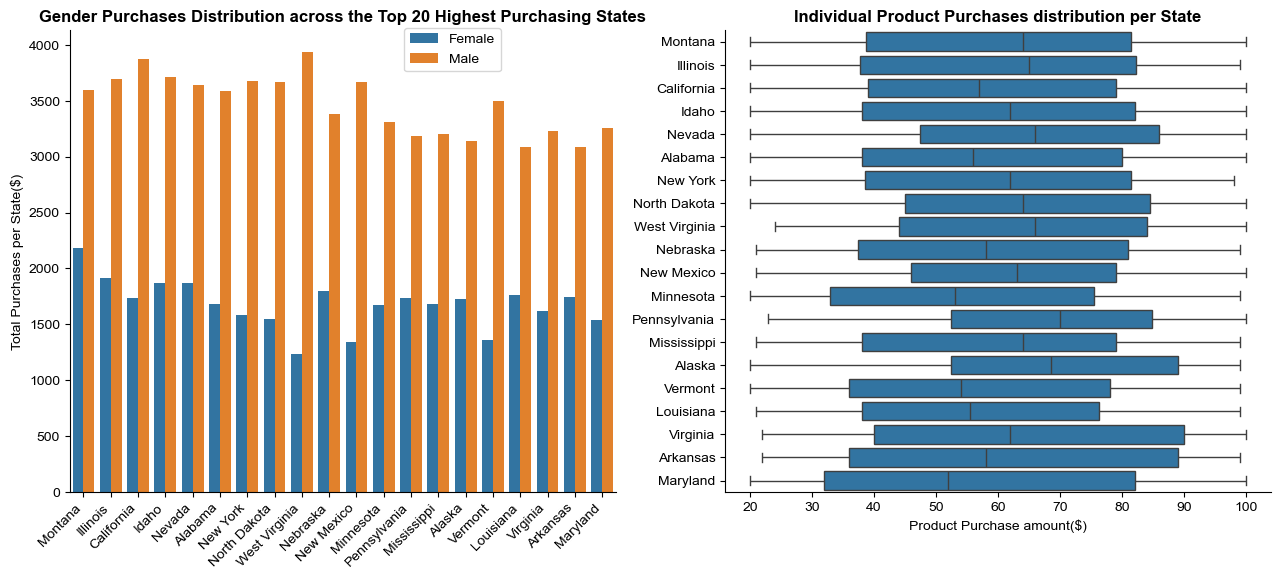

In [2]:
TopLocationSales=df_cust.groupby('Location')['Purchase Amount (USD)'].sum().sort_values(ascending=False).head(20).to_frame(name='Total Purchases').reset_index()
LocationTop20=TopLocationSales['Location'].to_list()
Top20Purchases=df_cust[df_cust['Location'].isin(LocationTop20)]
Top20Purchases_bar=Top20Purchases.pivot_table(values='Purchase Amount (USD)',index=['Location','Gender'],aggfunc='sum')

fig,ax=plt.subplots(1,2,figsize=(15.5,6))
sns.barplot(data=Top20Purchases_bar,x='Location',y='Purchase Amount (USD)',order=LocationTop20,ax=ax[0],hue= 'Gender')
sns.despine()
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
ax[0].set_title('Gender Purchases Distribution across the Top 20 Highest Purchasing States',fontweight='bold')
ax[0].legend(loc='best',bbox_to_anchor=(0.6,1.02))
ax[0].set_xlabel('')
ax[0].set_ylabel('Total Purchases per State($)')


# The States start from the highest purchasing to lowest from the top of the y-axis
LocationTop20=TopLocationSales['Location'].to_list()
sns.boxplot(data=df_cust,y='Location',x='Purchase Amount (USD)',ax=ax[1],order=LocationTop20)
sns.set_theme(style='ticks')
sns.despine()
ax[1].set_title('Individual Product Purchases distribution per State', fontweight='bold')
ax[1].set_xlabel('Product Purchase amount($)')
ax[1].set_ylabel('')

plt.show()

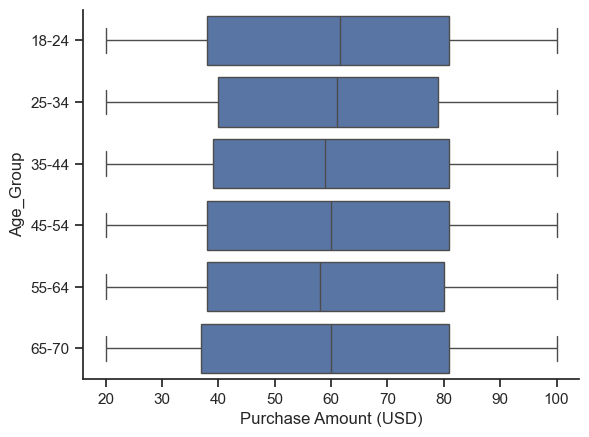

In [3]:
df_cust['Age']=df_cust['Age'].astype(int)

age_groups = [
    '18-24',
    '25-34',
    '35-44',
    '45-54',
    '55-64',
    '65-70'
]
def categorise_age(age):
    if 18<=age<=24:
        return '18-24'
    elif 25<=age<=34:
        return '25-34'
    elif 35<=age<=44:
        return '35-44'
    elif 45<=age<=54:
        return '45-54'
    elif 55<=age<=64:
        return '55-64'
    elif 65<=age<=70:
        return '65-70'
    else:
        return '70+'

df_cust['Age_Group']=df_cust['Age'].apply(categorise_age)

sns.boxplot(data=df_cust,y='Age_Group',x='Purchase Amount (USD)',order=age_groups)
sns.set_theme(style='ticks')
sns.despine()


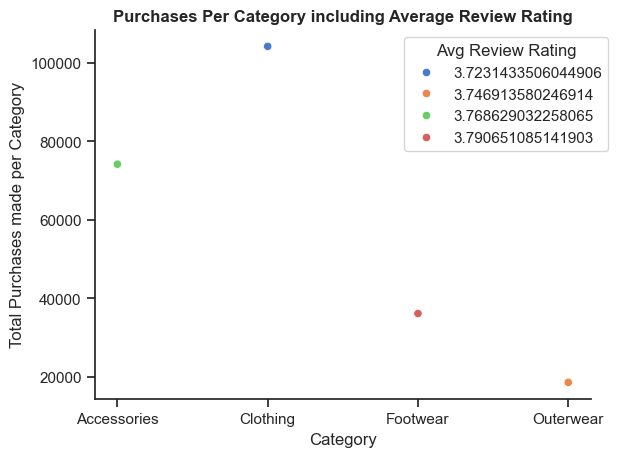

In [4]:
ReviewCategory=df_cust.groupby('Category')[['Purchase Amount (USD)','Review Rating']].agg(
    T_Purchase=('Purchase Amount (USD)','sum'),
    M_ReviewRating=('Review Rating','mean'))

sns.scatterplot(data=ReviewCategory,x='Category',y='T_Purchase',sizes=(50,200),hue='M_ReviewRating',palette='muted')
sns.despine()
plt.title('Purchases Per Category including Average Review Rating',fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Total Purchases made per Category')
plt.legend(loc='best',title='Avg Review Rating',bbox_to_anchor=(1.05,1))
plt.show()

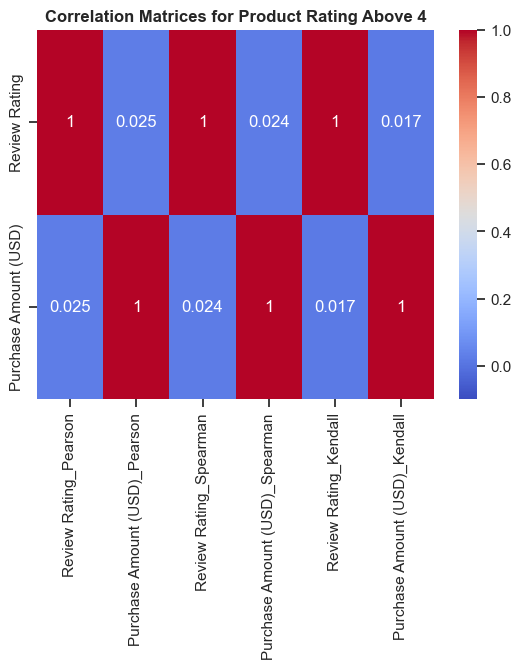

In [5]:
Above4Review=df_cust[df_cust['Review Rating']>4]
pearson_df=Above4Review[['Review Rating','Purchase Amount (USD)']].corr(method='pearson')
spearman_df=Above4Review[['Review Rating','Purchase Amount (USD)']].corr(method='spearman')
kendall_df=Above4Review[['Review Rating','Purchase Amount (USD)']].corr(method='kendall')
combined_matrx_A= pd.concat([
    pearson_df.add_suffix('_Pearson'),
    spearman_df.add_suffix('_Spearman'),
    kendall_df.add_suffix('_Kendall')
], axis=1)

combined_matrx_A

sns.heatmap(combined_matrx_A, annot=True, cmap='coolwarm', vmin=-0.1, vmax=1)
plt.title('Correlation Matrices for Product Rating Above 4',fontweight='bold')
plt.show()

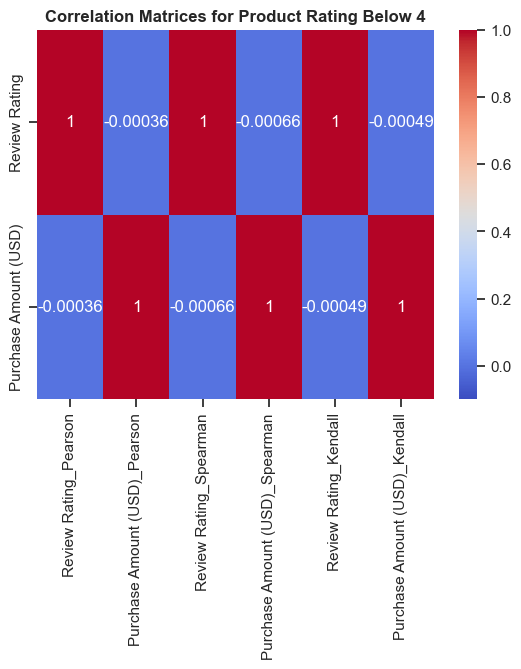

In [6]:
Below4Review=df_cust[df_cust['Review Rating']<4]
pearson_df=Below4Review[['Review Rating','Purchase Amount (USD)']].corr(method='pearson')
spearman_df=Below4Review[['Review Rating','Purchase Amount (USD)']].corr(method='spearman')
kendall_df=Below4Review[['Review Rating','Purchase Amount (USD)']].corr(method='kendall')
combined_matrx_B= pd.concat([
    pearson_df.add_suffix('_Pearson'),
    spearman_df.add_suffix('_Spearman'),
    kendall_df.add_suffix('_Kendall')
], axis=1)

combined_matrx_B
sns.heatmap(combined_matrx_B, annot=True, cmap='coolwarm', vmin=-0.1, vmax=1)
plt.title('Correlation Matrices for Product Rating Below 4',fontweight='bold')
plt.show()

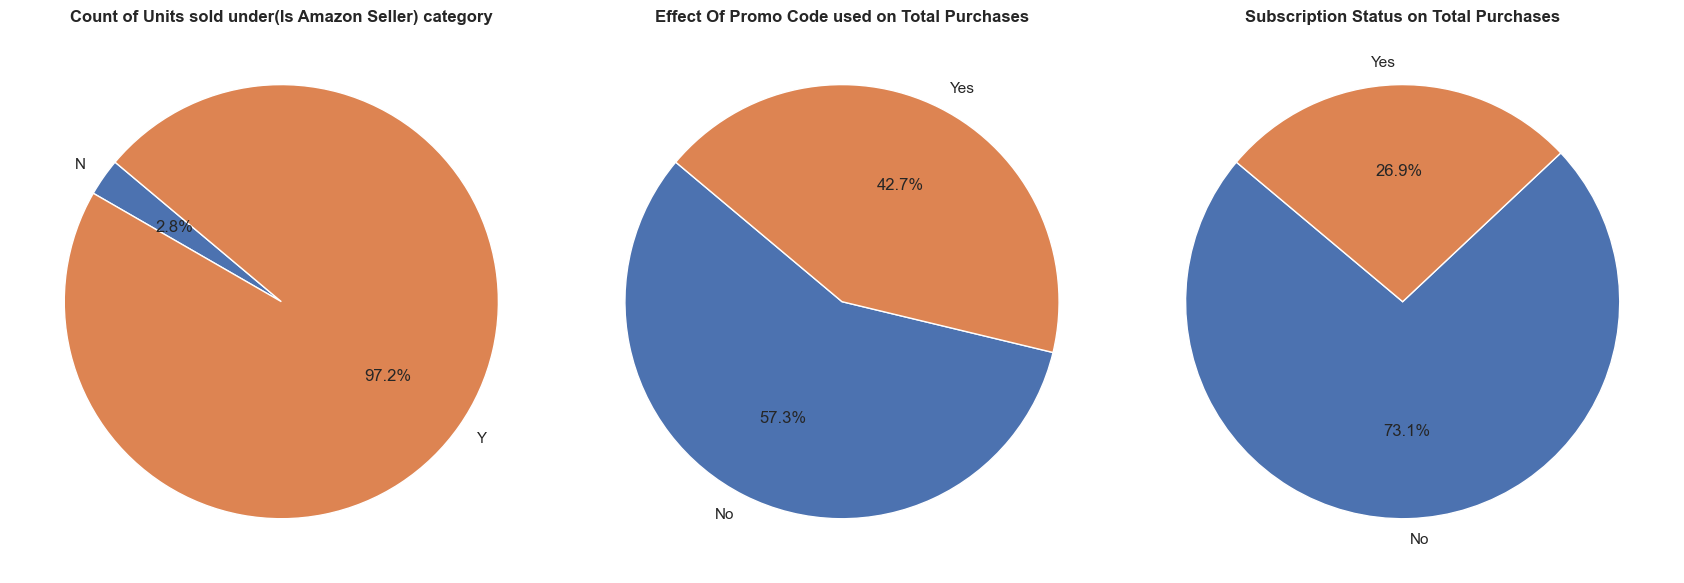

In [7]:
fig,ax=plt.subplots(1,3,figsize=(17,6))

AmazonSeller=df_prod.groupby('Is Amazon Seller')['Selling Price'].agg(['mean','size']).reset_index()
sizes1=AmazonSeller['size']
labels1=AmazonSeller['Is Amazon Seller']

ax[0].pie(sizes1,labels=labels1,autopct='%1.1f%%',startangle=140)
ax[0].set_title('Count of Units sold under(Is Amazon Seller) category',fontweight='bold')

promo_code_used=df_cust.groupby('Promo Code Used')[['Purchase Amount (USD)']].agg(T_Purchase=('Purchase Amount (USD)','sum')).reset_index()
sizes2 = promo_code_used['T_Purchase']
labels2 = promo_code_used['Promo Code Used']
ax[1].pie(sizes2,labels=labels2,autopct='%1.1f%%',startangle=140)
ax[1].set_title('Effect Of Promo Code used on Total Purchases',fontweight='bold')

subscription_status=df_cust.groupby('Subscription Status')[['Purchase Amount (USD)']].agg(
    T_Purchase=('Purchase Amount (USD)','sum')).reset_index()
sizes3 = subscription_status['T_Purchase']
labels3 = subscription_status['Subscription Status']
ax[2].pie(sizes3,labels=labels3,autopct='%1.1f%%',startangle=140)
ax[2].set_title('Subscription Status on Total Purchases',fontweight='bold')

plt.tight_layout()
plt.show()
